# Predicting Time to Destination with NYC Taxi Data

#### Mike Alvarino maa2282 $|$ Colby Wise cjw2165

## Introduction

The NYC Taxi and Limousine Commission (TLC) released a dataset consisting of ~1.2 billion individual yellow and green taxi trips in the city from 2009 onward. For our presentation, we utilized the most recent and complete six month sample of data which at the time of this project was the 2016 data. Additionally, given the size of the dataset we further restricted our dataset to include only yellow cab data within Manhattan.

We can never know the exact algorithm in use by many of popular travel time prediction engines such as Google Maps or Bing Maps. That said, research [1] indicates that many popular engines crowdsource a combination of real-time traffic report data and more recently, user-sourced traffic condition reports (i.e. Waze). From this the estimated trip duration: 

$$\frac{trip\_distance}{est\_speed} + traffic\_time$$

## Problem Formulation

In this project our goal is to approach the trip time estimate problem from the perspective of probabilistic programming and [Box's Loop](https://am207.github.io/2017/wiki/boxloop.html). Specifically, our intent is to use the NYC Taxi and Limousine Commission's yellow cab data to estimate travel time between pickups and dropoffs within Manhattan. The project is build using [Edward](http://edwardlib.org/), a Python library for probabilistic modeling, inference, and criticism.

Throughout our presentation we will be using the example of a traveler visiting New York whose goal is to accurately predict estimated travel time to destinations throughout the day. Our hypothetical traveler wants the most accurate trip time estimates possible.

In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
import kernels
pd.set_option('float_format', '{:f}'.format)
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Description of Dataset

The [NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml), consists of pickup and dropoff coordinates for trips, along with metadata like cost, distance, and number of passengers. Columns we expect to find especially useful are those that could affect the time to destination and, obviously, are not known in advance of the trip.Since our dataset was large even after limiting it to only six months and Manhattan, (~1.8 million trips) we segmented the data by neighborhood.

Getting back to our unfamiliar traveler, one example query will want to answer is:

_How much time will it take to get to my friend on the Upper East Side at noon tomorrow coming from Morningside Heights?_

### Key Data Metrics
_Limited to Manhattan_

**Total Samples**: 1,760,396  
**Date Range:** 1/1/2016 - 07/01/2016  
**Borough Mapping:** Longitude/Latitude & 2010 NYC Census Tract Data 

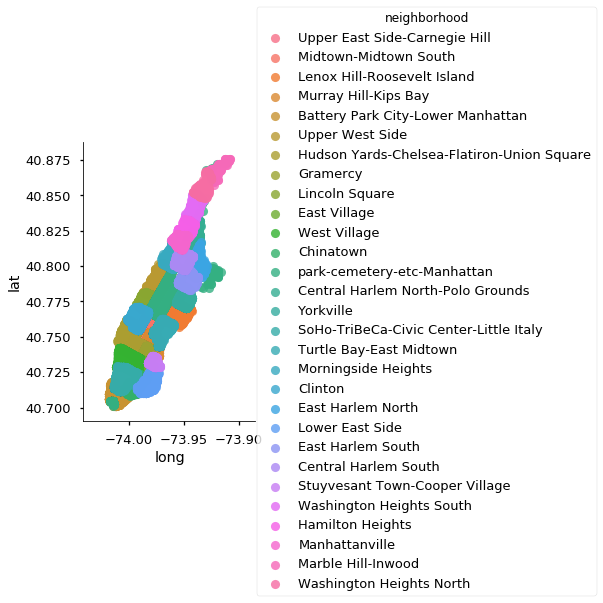

In [2]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")
rand_indices = np.random.choice(manhattan.shape[0], size=int(0.1 * manhattan.shape[0]), replace=False)
visualizations.visualize_by_borough(manhattan.iloc[rand_indices, :])
plt.show()

#### Training vs Test

Train Size: $\%80$  
Test Size: $\%20$  

#### Limiting Columns
Limit our dataset $X$ to the following columns:   
1. pickup_latitude  
1. pickup_longitude
1. dropoff_latitude
1. dropoff_longitude
1. manhattan_distance
1. pickup_hour
1. pickup_timestamp

Limit $y$ to the following:
1. trip_duration

#### Standardization
Note that we standardize our data such that $x \sim N(0, 1)$

In [3]:
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)
indicator_cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "manhattan_distance", "pickup_hour", "pickup_timestamp"]
y_cols = ["trip_duration"]
x_train_raw, y_train_raw, x_test_raw, y_test_raw = data.train_test_split(ues_to_msh, 0.2, indicator_cols, y_cols)

x_train = data.standardize_cols(x_train_raw)
x_test = data.standardize_cols(x_test_raw)
vis = x_train_raw.copy(deep=True)
vis["trip_duration"] = y_train_raw.copy(deep=True)

# Box's Loop - Iteration 1

## Model: Bayesian GLM

For our first iteration of Box's Loop, we started with a Bayesian General Linear Model, a common baseline for regression models and a good starting point for the Gaussian Process we will be working towards. The model can be framed as the following:


$$f(X) = X^Tw$$
$$y = f(X) + b$$



Where $X$ is the data, $w$ is a vector of weights, $y$ is the prediction, and where
$b \sim N(0, \sigma^2_n)$

We construct the model as follows:

*Normal Prior $w$* = *p(w)* = $N(w\ |\ 0,\ \sigma^2_w I)$

*Normal Prior $b$* = *p($b$)* = $N(b\ |\ 0,\ \sigma^2_b)$

*Likelihood* = *p(y | w,$\epsilon$,X)* = $\prod^N_{n=1} N(y_n\ |\ X^Tw + b)$

*Posterior* = $p(w,\ b|\ y,\ X) \approx p(y\ |\ w,\ b,\ X)\ p(w)\ p(b)$

In [4]:
N, D = x_train.shape
X = tf.placeholder(tf.float32, [N, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=[0.0], scale=1.0)

Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=[1.0])

# Inference

Here we use [Edward's KLqp](http://edwardlib.org/api/ed/KLqp) algorithm to perform inference over the model, allowing our $y$ scale to vary.

In Bayesian statistics the Kullback–Leibler divergence *KL(q||p)* is used as a measure of the information gain in moving from a prior distribution to a posterior distribution. Or more generally, how much information is lost when Q is used to approximate P. When model latent variables are differentiable, Edward will directly minimize the KL(q | p) divergence. If the latent variables are not differentiable, Edward maximizes the ELBO. In our case the priors are conjugate and our latent variables are differentiable.

In [5]:
qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                       scale=tf.Variable(tf.random_normal([D])))

qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference = ed.KLqp({w: qw, b: qb},
                    data={X: x_train.as_matrix(),
                          Y: y_train_raw.as_matrix().reshape(y_train_raw.shape[0])})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 6446.109


# Criticism

Here given it's just a baseline model we bypass more indepth model criticism and error analysis. Instead, we chose a commonplace and interpretable evaluation metric: *mean absolute error*.  

In [6]:
N, D = x_test.shape
X_eval = tf.placeholder(tf.float32, [N, D])
y_posterior_predictive = ed.models.Normal(loc=ed.dot(X_eval, qw) + qb, scale=[1.0])
print(ed.evaluate("mean_absolute_error",
                  data={X_eval: x_test.as_matrix(),
                        y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))},
                  output_key=y_posterior_predictive))

3.49282


Back to our example of a visiting traveller, we can easily see that a 9 to 10 minute average error is poor, so we would like to see what exactly our model has inferred.

By sampling a set of $(w,\ b)$ we can build 

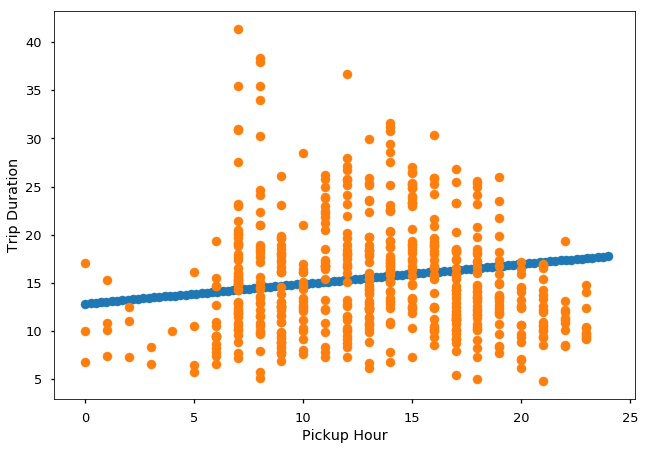

In [7]:
visualizations.vis_glm(100, indicator_cols, vis, qw, qb)

# Box's Loop - Iteration 2

## Model: GLM with Polynomial Basis Function

Moving on in the direction of Gaussian Processes, we would like to begin exploring basis functions. We will begin with a simple polynomial basis function, which is essentially a special case of multiple linear regression. Now we have the following mode:

$$f(\phi(X)) = \phi(X)^Tw$$
$$y = f(\phi(X)) + b$$

Where $\phi$ is the polynomial basis function. 

*We manually explored several polynomial degrees settling on a degree 2 polynomial.*

Where $X$ is the data, $w$ is a vector of weights, and $y$ is the prediction.

We construct the model as follows:

*Normal Prior $w$* = *p(w)* = $N(w\ |\ 0,\ \sigma^2_w I)$

*Normal Prior $b$* = *p($b$)* = $N(b\ |\ 0,\ \sigma^2_b)$

*Likelihood* = *p(y | w, $b$, $\phi(X)$)* = $\prod^N_{n=1} N(y_n\ |\ \phi(X)^Tw,\ \sigma^2_n)$

*Posterior* = $p(w,\ b\ |\ y,\ \phi(X)) \approx p(y\ |\ w,\ b,\ \phi(X))\ p(w)\ p(b)$

In [21]:
poly_degree = 4

x_train_2 = basis_functions.polynomial(x_train, degree=poly_degree)
x_test_2 = basis_functions.polynomial(x_test, degree=poly_degree)

In [22]:
N_2, D_2 = x_train_2.shape
X_2 = tf.placeholder(tf.float32, [N_2, D_2])
w_2 = ed.models.Normal(loc=tf.zeros(D_2), scale=tf.ones(D_2))
b_2 = ed.models.Normal(loc=[0.0], scale=1.0)
Y_2 = ed.models.Normal(loc=ed.dot(X_2, w_2) + b_2, scale=[1.0])

# Inference

Again, we will use KLqp inference

In [23]:
qw_2 = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D_2])),
                                       scale=tf.Variable(tf.random_normal([D_2])))

qb_2 = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference_2 = ed.KLqp({w_2: qw_2, b_2: qb_2},
                    data={X_2: x_train_2.as_matrix(),
                          Y_2: np.reshape(y_train_raw.as_matrix(), (y_train_raw.shape[0]))})
inference_2.run(n_iter=3000)

3000/3000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 5720.429


# Criticism

The graph below is a showing our training data **orange** vs samples from our predictive distribution **blue**.

(100, 28)


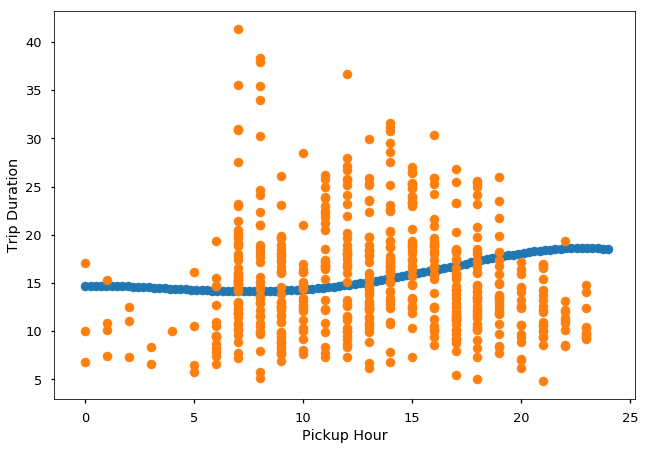

In [24]:
x_vis = pd.DataFrame({i: [0.0] * 100 for i in x_train_2.columns})
print(x_vis.shape)
visualizations.vis_glm_poly(100, poly_degree, indicator_cols, vis, qw_2, qb_2)


### Mean Absolute Error

The mean absolute error has improved our model. Specifically, our error has shrunk by just under one minute.

**MAE GLM:** ~3.60

**MAE Poly GLM:** ~3.02


In [25]:
N_2, D_2 = x_test_2.shape
X_eval_2 = tf.placeholder(tf.float32, [N_2, D_2])
y_posterior_predictive_2 = ed.models.Normal(loc=ed.dot(X_eval_2, qw_2) + qb_2, scale=[1.0])
print(ed.evaluate("mean_absolute_error",
            data={X_eval_2: x_test_2.as_matrix(),
                  y_posterior_predictive_2: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))},
             output_key=y_posterior_predictive_2))

3.12746


### Posterior Predictive Checks

Now, in order to get a better understanding as to the validity of our model, specifically the data generating process we will use posterior predictive checks. Posterior predictive checks allow us to simulate data from our fitted model (posterior) and compare results with the real data. While it does not tell us if our model is "good", discrepancies can tell us if the model makes sense. 

**Mean:** The mean lies in a region of high probabilities density. It does not indicate anything abnormal

**Min:** The minimum lies in a lower region of the sample distribution but not abnormally.

**Max:** The maximum lies far away from the distribution.

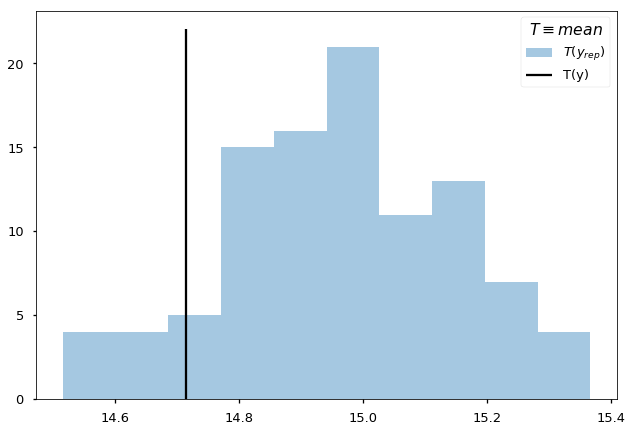

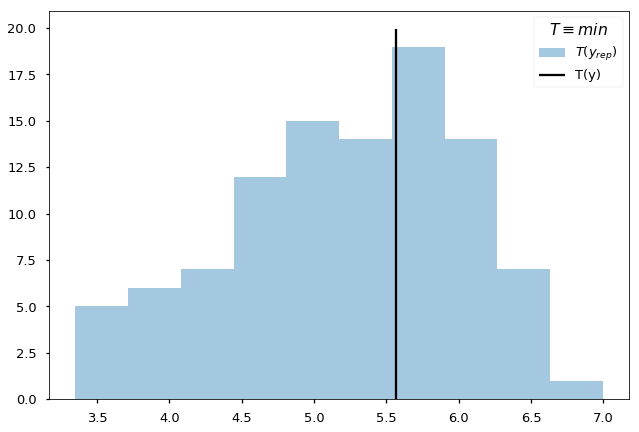

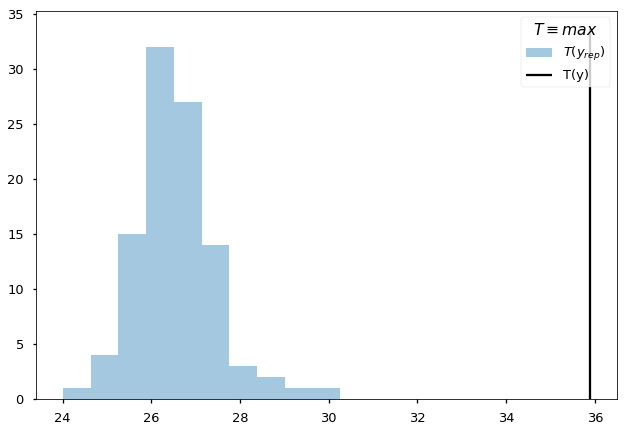

In [27]:
def T_max_2(data_dict, latent_vars_dict):
    return tf.reduce_max(data_dict[y_posterior_predictive_2])
def T_min_2(data_dict, latent_vars_dict):
    return tf.reduce_min(data_dict[y_posterior_predictive_2])
def T_mean_2(data_dict, latent_vars_dict):
    return tf.reduce_mean(data_dict[y_posterior_predictive_2])
ppc_stats_max_2 = ed.ppc(T_max_2,
                             data={
                                 X_eval_2: x_test_2.as_matrix(),
                                 y_posterior_predictive_2: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w_2: qw_2, b_2: qb_2}
                      )
ppc_stats_min_2 = ed.ppc(T_min_2,
                             data={
                                 X_eval_2: x_test_2.as_matrix(),
                                 y_posterior_predictive_2: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w_2: qw_2, b_2: qb_2}
                      )
ppc_stats_mean_2 = ed.ppc(T_mean_2,
                             data={
                                 X_eval_2: x_test_2.as_matrix(),
                                 y_posterior_predictive_2: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w_2: qw_2, b_2: qb_2}
                      )

ed.ppc_stat_hist_plot(ppc_stats_mean_2[1][1], ppc_stats_mean_2[0], stat_name=r'$T \equiv mean$',
    bins=10)
plt.show()
ed.ppc_stat_hist_plot(ppc_stats_min_2[1][1], ppc_stats_min_2[0], stat_name=r'$T \equiv min$',
    bins=10)
plt.show()
ed.ppc_stat_hist_plot(ppc_stats_max_2[1][1], ppc_stats_max_2[0], stat_name=r'$T \equiv max$',
    bins=10)
plt.show()